In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import os
import pickle

import numpy as np
import pandas as pd
import scipy as sp
from sklearn.feature_selection import f_classif
import torch as t
import torch.nn.functional as f
import xarray as xr
import plotly.express as px
import plotly as py
import plotly.subplots
import plotly.graph_objects as go
from einops import rearrange, repeat
from IPython.display import Video, display
from tqdm.auto import tqdm
import warnings

# NOTE: this is Monte's RL hooking code (and other stuff will be added in the future)
# Install normally with: pip install circrl
import circrl.module_hook as cmh
import circrl.rollouts as cro
import circrl.probing as cpr

import procgen_tools.models as models
import procgen_tools.maze as maze

warnings.filterwarnings("ignore", message=r'.*labels with no predicted samples.*')

# Hack to make sure cwd is the script folder
os.chdir(globals()['_dh'][0])

In [3]:
import procgen_tools

from procgen_tools.utils import setup

setup() # create directory structure and download data 

Already downloaded https://drive.google.com/uc?id=17p6aFRIHIilP_3toWqbUbpl4jY4A2x5O


In [4]:
from procgen_tools.imports import *
from procgen_tools.procgen_imports import *
from procgen_tools import visualization

/mnt/h/programming/procgen-tools/procgen_tools/models.py:234: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_file, map_location=device)


# Identifying Context

One of the core ideas of Shard Theory is that shards are activated depending on context, and that this context is based on the world model of the agent, and not necessarily by the sensory input the agent receives. While the technical definition of a shard is still not precise, we can test some of the ideas behind this description of shard mechanics through already existing agents in the literature.

For this notebook, we will investigate the maze-solving agent trained by Langosco et al. and we will build upon some of the insights provided by the Shard Theory team under SERI MATS 3.0. Their investigation was focused on identifying cheese-subshards, and verifying the feasibility of modifying the agent's behavior by patching cheese subshards in intuitive ways.

The work for this notebook will be to investigate the claim that context might affect the activation of shards, and influence agent's behavior. One of the established hypothesis by the Shard Theory team while investigating this agent is that it has two competing goals: Reaching the top-right corner, and reaching the cheese. This hypothesis is presented and briefly questioned through some visualizations of the agent's behavior on a given level, but further analysis is left for future work. 

In [5]:
default_settings = {'channel_slider': 55, 'label_widget': 'block2.res1.resadd_out'}

In [6]:
# Show a maze editor side-by-side with the interactive plotter
SEED = 0
venv = create_venv(num=1, start_level=SEED, num_levels=1) # This has to be a single maze, otherwise the vfield wont work

In [7]:
custom_maze_plotter = ActivationsPlotter(labels, lambda activations, fig: plot_activations(activations[0], fig=fig), values_from_venv, hook, defaults=default_settings, venv=venv)

widget_box = custom_vfield(policy, venv=venv, callback=custom_maze_plotter.update_plotter, show_components=False) 
display(widget_box)
    
custom_maze_plotter.display() 
# TODO make it so that it's easy to attach notes to files, load  

Box(children=(HBox(children=(GridspecLayout(children=(Button(layout=Layout(grid_area='widget001', height='0px'…

FigureWidget({
    'data': [{'colorscale': [[0.0, 'rgb(103,0,31)'], [0.1, 'rgb(178,24,43)'],
                             [0.2, 'rgb(214,96,77)'], [0.3, 'rgb(244,165,130)'],
                             [0.4, 'rgb(253,219,199)'], [0.5, 'rgb(247,247,247)'],
                             [0.6, 'rgb(209,229,240)'], [0.7, 'rgb(146,197,222)'],
                             [0.8, 'rgb(67,147,195)'], [0.9, 'rgb(33,102,172)'],
                             [1.0, 'rgb(5,48,97)']],
              'type': 'heatmap',
              'uid': 'c3654380-538d-4e21-8bfd-5d3988fcdf0c',
              'z': array([[ 0.02657299, -0.02839125, -0.07341541, ..., -0.04391609, -0.0239433 ,
                           -0.01430185],
                          [-0.00080868, -0.16516905, -0.19377661, ..., -0.17952022, -0.13850096,
                           -0.08350438],
                          [-0.06065884, -0.24889266, -0.23197651, ..., -0.21075162, -0.19989595,
                           -0.19339341],
                  

The Shard Theory team use the maze and policy above to analyze the competing goals hypothesis. They briefly mention that the interaction between goals doesn't seem to be as straightforward as expected, observing how the agent doesn't seem to direct itself towards the 5x5 top-right corner, and instead the policy appears to point to a point further below this corner.

![](https://res.cloudinary.com/lesswrong-2-0/image/upload/f_auto,q_auto/v1/mirroredImages/cAC4AXiNC5ig6jQnc/o24edwffjw5id3xexkjp)

Additionally, it seems strange that even though the agent doesn't arrive to the top-right corner, it still strives to go towards it for the most part, even ignoring the cheese.

This prompted the following hypothesis on my behalf: The cheese shard is more relevant the closer you are to the top-right corner, due to the training distribution, and due to the fact that the agent needs to care about the location of the cheese to make sure it picks the right path.

## Determining the cheese-shard context

A quick test to determine the feasibility of this hypothesis is to observe the difference in behavior between a map with cheese and one without it. To remove additional variables, using a completely empty map is ideal.

In [8]:
def set_obj_pos(grid, start_idx, obj_val, obj_pos):
    obj_x, obj_y = obj_pos
    obj_x += start_idx
    obj_y += start_idx
    grid[obj_y, obj_x] = maze.EMPTY
    grid[obj_y, obj_x] = obj_val

def set_empty_maze(venv,
    size=25,
    empty_grid_val=100,
    cheese_loc: tuple[int, int] | None =None,
    mouse_loc: tuple[int, int] = (0, 0),
):

    # assert mouse_loc != cheese_loc, "Cheese and mouse can't be in the same location"
    assert size % 2 == 1, "Maze size can't be even"
    padding = (25 - size) // 2
    start, end = padding , 25 - padding
    sb = venv.env.callmethod("get_state")
    env_state = maze.EnvState(sb[0])
    grid = maze.BLOCKED * np.ones((25, 25), dtype=int)
    grid[start:end, start:end] = empty_grid_val
    set_obj_pos(grid, start, maze.MOUSE, mouse_loc)
    if cheese_loc is not None:
        set_obj_pos(grid, start, maze.CHEESE, cheese_loc)
    env_state.set_grid(grid)
    venv.env.callmethod("set_state", [env_state.state_bytes])

    return venv

# set_empty_maze(venv, size=15)

In [9]:
def empty_maze_cheese_vfields(cheese_loc: tuple[int, int], policy, size=25, mouse_loc: tuple[int, int] = (0, 0)):
    venv = create_venv(num=1, start_level=0, num_levels=1)
    set_empty_maze(venv, size=size, mouse_loc=mouse_loc)
    cheese_env = maze.copy_venv(venv, 0)
    set_empty_maze(cheese_env, size=size, cheese_loc=cheese_loc, mouse_loc=mouse_loc)

    venv_vfield = visualization.vector_field(venv, policy)
    cheese_vfield = visualization.vector_field(cheese_env, policy)

    viz.plot_vfs(venv_vfield, cheese_vfield)

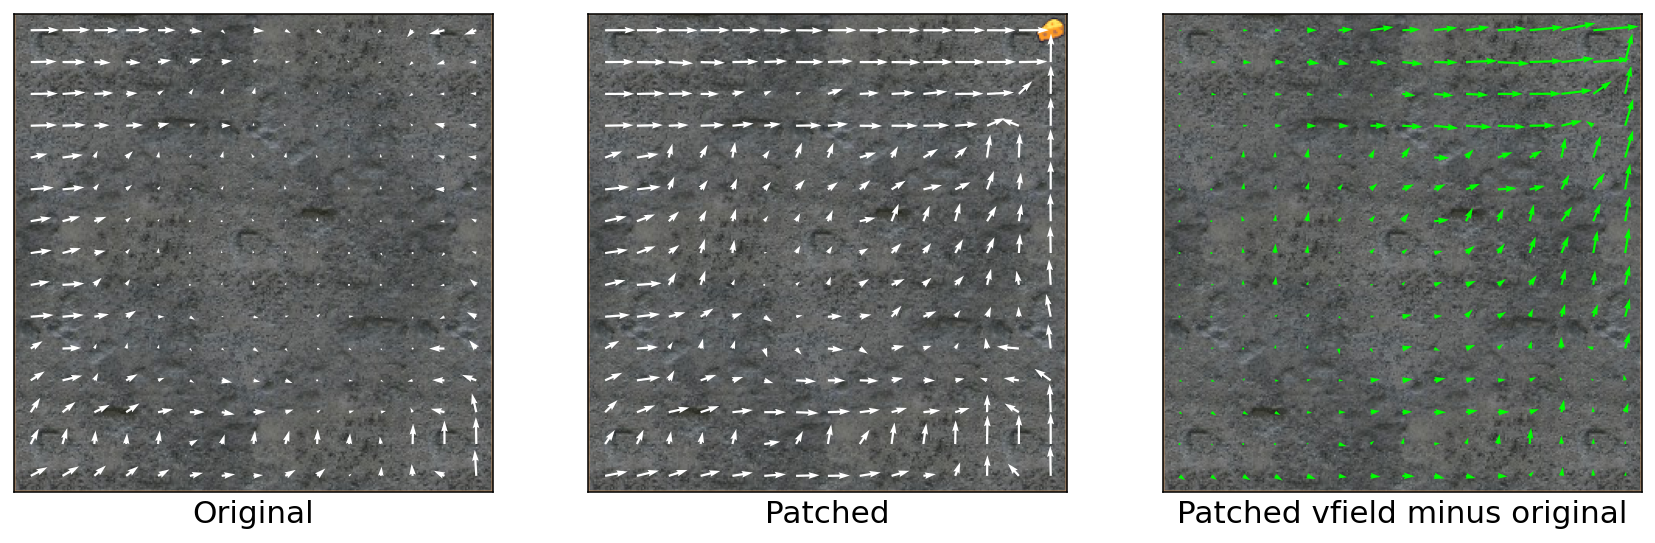

In [10]:
empty_maze_cheese_vfields((14, 14), policy, size=15)

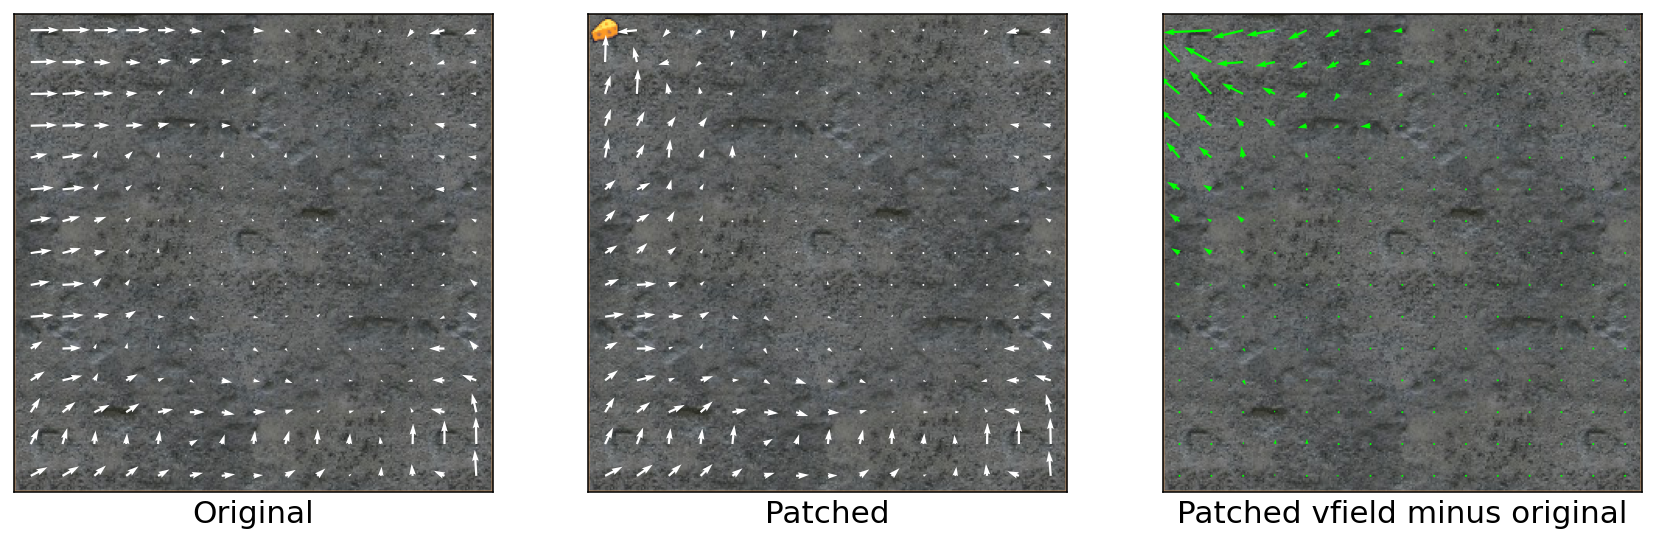

In [11]:
empty_maze_cheese_vfields((0, 14), policy, size=15)

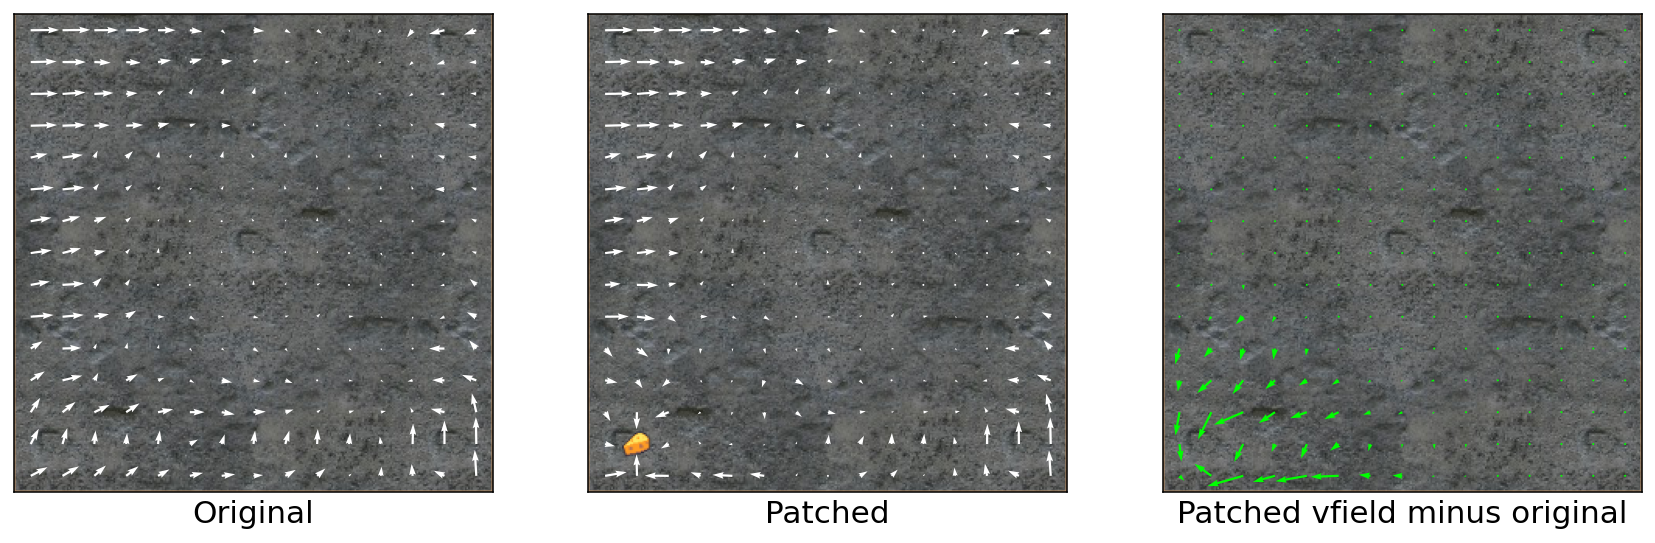

In [12]:
empty_maze_cheese_vfields((1, 1), policy, size=15, mouse_loc=(1, 1))

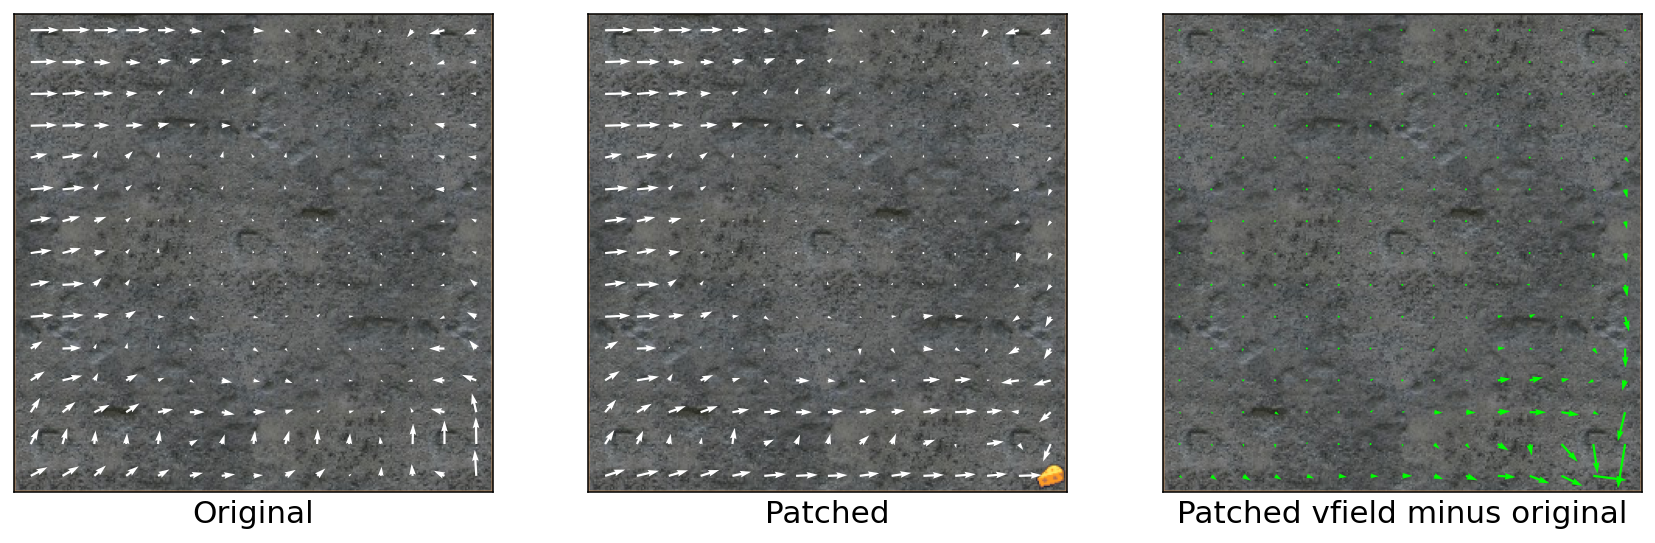

In [13]:
empty_maze_cheese_vfields((14, 0), policy, size=15)

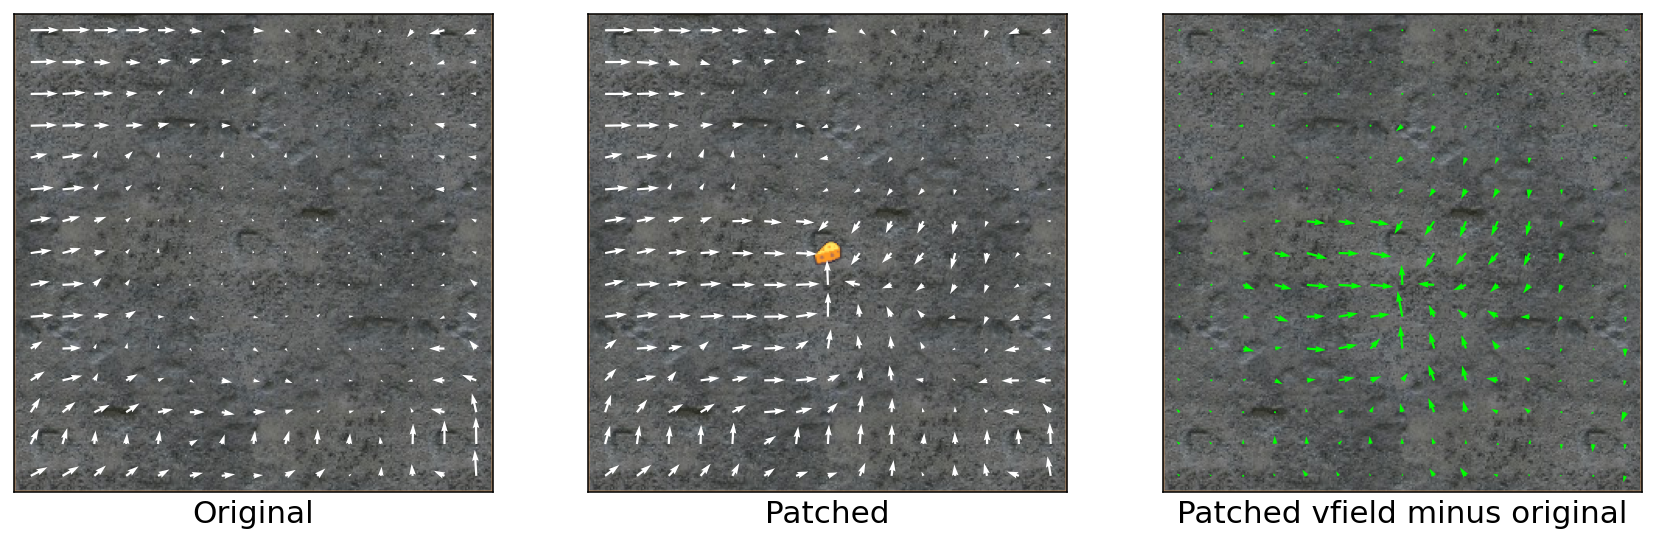

In [14]:
empty_maze_cheese_vfields((7, 7), policy, size=15)

The previous visualizations demonstrate the influence of the cheese in the policy at different corners. The top-right corner demonstrates the strongest cheese-influence, due to being inside the training distribution. Meanwhile, all the other positions demonstrate a weak and localized influence of the cheese.

An interesting behavior to highlight is how the policy seems to only be clearly defined at the edges of the map, while at the center and top-right edge have arbitrary behavior.

This sudden change in "decisiveness" might point towards the agent caring more about the position of the cheese when the mouse is near the center and top-right edge than in any other location.

Another hypothesis that can be further investigated is how the influence of the cheese is direction-aware. Given how the training environment behaves, the agent might learn to care more about the cheese when the mouse is in the third quadrant relative to the position of the cheese. In any other quadrant, the influence of the cheese is weaker, because the agent never learned to care about cheese in any other location.

Lastly, it seems that in some contexts, the effect the cheese has on the behavior of the agent near the other borders is weak or non-existent. This raises the question: **Does the agent even care about where the cheese is near the borders?**

## Analysing the cheese context boundary
Having determined that the cheese has a localized influence on the agent's policy, and that the behavior of the agent near the borders is largely unaffected, raises the following questions: **Does the agent even care about where the cheese is near the borders?**

This question could be defined more technically with the following hypothesis: 

**The agent policy does not codify the position or existence of the cheese near the borders.**

This hypothesis can be tested through linear probing!

### Testing cheese awareness
In order to determine whether the agent is aware of the cheese at a certain point in the maze, we can generate a synthetic dataset where the cheese position is fixed, but the cheese is placed and removed and the position of the mouse is changed in every iteration. We could then probe the deeper layers of the network to see if it is possible to predict the existence of the cheese by observing the activations of the given layers.

If the hypothesis is correct, the linear probes will not be able to accurately predict the existence of cheese in the deeper layers when the mouse is near the borders, but it will be able to predict it once the mouse is inside the area of influence of the cheese.

In [15]:
def gen_env_setup(cheese_loc=(14, 14), size=15, cheese_prob=0.5):
    if cheese_loc == "random":
        cheese_loc = set(np.random.choice(size, size=2))
    orig_venv = create_venv(num=1, start_level=SEED, num_levels=1)
    no_cheese_venv = set_empty_maze(orig_venv, size)
    no_cheese_venvs = maze.venv_with_all_mouse_positions(no_cheese_venv)[0]
    cheese_venv = set_empty_maze(orig_venv, size, cheese_loc=cheese_loc)
    cheese_venvs = maze.venv_with_all_mouse_positions(cheese_venv)[0]

    def setup_env():
        sample_venvs = no_cheese_venvs
        if np.random.rand() >= cheese_prob:
            sample_venvs = cheese_venvs
        sample_idx = np.random.choice(sample_venvs.num_envs)
        venv = copy_venv(sample_venvs, sample_idx)
        episode_metadata = dict(start_level=SEED, 
            level_seed=int(venv.env.get_info()[0]["level_seed"]))

        return venv, episode_metadata

    return setup_env

In [16]:
import experiments.gatherdata_rich as gatherdata_rich

setup_env = gen_env_setup("random")
model_name = "model_rand_region_5"
# gatherdata_rich.get_maze_dataset(policy, model_name, 10000, 
#         1, env_setup_func=setup_env)

In [17]:
values_to_store = [
    'embedder.block1.conv_in0',
    'embedder.block1.res1.resadd_out',
    'embedder.block1.res2.resadd_out',
    'embedder.block2.res1.resadd_out',
    'embedder.block2.res2.resadd_out',
    'embedder.block3.res1.resadd_out',
    'embedder.block3.res2.resadd_out',
    'embedder.flatten_out',
    'embedder.relufc_out',
    'fc_policy_out',
]

# This limits the number of mazes to look for faster exploration
num_batch = 1000

# 10k run, only mazes with dec square, obs saved on dec square
dr = '../episode_data/20240904T012150/'
fn = 'postproc_probe_data.pkl'
state_bytes_key = 'dec_state_bytes'

# Load data from post-processed pickled file
with open(os.path.join(dr, fn), 'rb') as fl:
    data_all = pickle.load(fl)['data']
    num_batch_to_use = min(num_batch, len(data_all))
    data_all = data_all[:num_batch_to_use]

# Pull out the observations into a single batch
batch_coords = np.arange(len(data_all))
obs_all = xr.concat([dd['obs'] for dd in data_all], 
    dim='batch').assign_coords(dict(batch=batch_coords))

# Pull out level seeds for later reference
level_seeds = np.array([maze.EnvState(dd[state_bytes_key]).state_vals['current_level_seed'].val for
    dd in data_all])

# Pull out the maze dim for later reference
maze_dims = np.array([maze.EnvState(dd[state_bytes_key]).state_vals['maze_dim'].val for
    dd in data_all])

# Set up model and hook it
model_file = 'trained_models/maze_I/model_rand_region_5.pth'
policy = models.load_policy(model_file, action_size=15, device=t.device('cpu'))
model_name = os.path.basename(model_file)
hook = cmh.ModuleHook(policy)

# Run obs through model to get all the activations
_ = hook.run_with_input(obs_all)

/mnt/h/programming/procgen-tools/procgen_tools/models.py:234: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [18]:
cheese_exists = np.array([dd['cheese_node'] is not None for dd in data_all], dtype=int)

In [19]:
index_nums = np.array([1, 2, 5, 10, 100, 500])
results, _ = cpr.sparse_linear_probe(hook, ['fc_policy_out', 'embedder.block1.res1.resadd_out'], 
    cheese_exists, index_nums=index_nums, random_state=42, class_weight='balanced')

pd.DataFrame({'num_activations': index_nums, 'test_score': results.score.isel(value_label=0).values}).set_index('num_activations')

  0%|          | 0/2 [00:00<?, ?it/s]

/home/rano/anaconda3/envs/procgen/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning:

Features [   68   444   895  1015  1027  1066  1309  1918  2098  2306  2462  3060
  3584  3987  4100  4290  4546  4706  5014  5207  6653  7179  7220  7807
  8925  9372 10654 10815 12224 12225 13267 13335 14076 14270 14426 14448
 14941 15230 15262 15359 15388 15406 15439 15806 16346 16540 16832 17183
 17186 17377 18355 18532 19040 19620 20131 20286 20765 21529 22269 22615
 23569 23575 23629 23713 24661 24703 25535 26569 26708 28543 28994 29277
 29470 29710 29726 29750 30660 30752 30806 30976 31485 32354 32641 32745
 32855 32876 33865 34867 35100 35164 35946 35994 36348 37121 37216 37597
 37800 38931 38952 39009 39708 39711 40040 40386 41854 42084 42141 42755
 43137 43294 43994 44068 44982 45280 45471 46880 46915 47110 47715 47805
 48112 48120 48896 49130 49135 49136 49143 49152 49256 49825 49923 50157
 50158 50336 50658 51072 51304 52129 52166 52541 53297 

test_score
num_activations            
1                      0.71
2                      0.71
5                      0.77
10                     0.75
100                    0.91
500                    0.91

In [20]:
index_nums = np.array([1, 10, 50, 100, 500, 1000])
value_labels_to_plot = [
    'embedder.block1.conv_in0',
    'embedder.block1.res1.resadd_out',
    'embedder.block1.res2.resadd_out',
    'embedder.block2.res1.resadd_out',
    'embedder.block2.res2.resadd_out',
    'embedder.block3.res1.resadd_out',
    'embedder.block3.res2.resadd_out',
    'embedder.fc_out',
    'fc_policy_out',
]

results, _ = cpr.sparse_linear_probe(hook, value_labels_to_plot, 
    cheese_exists, index_nums=index_nums, random_state=42, class_weight='balanced')

pd.DataFrame({'num_activations': index_nums, 'test_score': results.score.isel(value_label=0).values}).set_index('num_activations')

def plot_sparse_probe_scores(results, y, index_nums, title, include_limits=True):
    scores_df = results.score.to_dataframe().reset_index()
    scores_df['K'] = index_nums[scores_df['index_num_step']]
    fig = px.line(scores_df, x='value_label', y='score', color='K', title=title)
    if include_limits:
        fig.add_hline(y=1., line_dash="dot", annotation_text="perfect", annotation_position="bottom right")
        baseline_score = abs(y.mean()-0.5) + 0.5
        fig.add_hline(y=baseline_score, line_dash="dot", annotation_text="baseline", 
                annotation_position="bottom right")
    fig.show()

plot_sparse_probe_scores(results, cheese_exists, index_nums, 
    f'Probe score over layers and K-values for cheese existence"')

  0%|          | 0/9 [00:00<?, ?it/s]

/home/rano/anaconda3/envs/procgen/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning:

Features [   68  1015  1027  1066  1309  1918  2098  2306  2462  3060  3255  3584
  3772  3999  4064  4100  4290  4546  5018  5207  5242  6079  6396  6688
  7179  7220  8315  8925  9372  9471 10654 10815 12224 12225 13267 13335
 14270 14426 14432 14448 14941 15262 15359 15388 15439 15447 15806 16346
 16540 16832 17183 17186 17301 17377 18299 18446 19040 19537 19585 19620
 20131 20286 21087 22269 22501 22615 23569 23575 23713 23744 24617 24703
 25535 26569 26668 26708 27707 28543 28994 29085 29277 29470 29613 29726
 29750 29980 30660 30752 30806 30810 31389 31485 32354 32641 32745 32855
 32876 35100 35612 35874 35946 37216 37597 37800 38872 38931 38952 39009
 40221 40386 41603 41854 42084 42141 42755 42912 43137 43294 44068 44982
 45073 45280 46621 46880 46915 47091 47110 47805 48042 48112 48120 48896
 49135 49136 49143 49152 49256 49923 50157 50158 50336 

Probing for the existence of cheese when both the mouse and the cheese can appear in any location of the map doesn't appear to confirm the hypothesis. The capacity of detecting cheese falls down a bit on the policy layer, which makes sense as the logits for deciding the next goal are extremely local, which means it may be hard to determine if the cheese exists just by looking at where the mouse will move next. Still, it does a lot better than guessing, which is rather interesting.

This graph alone shows some interesting paths to explore:
- Why the sudden drop in performance for 100 neurons and below in the `embedder.block1.res1.resadd_out` layer?
- Why is the agent so good at detecting the presence of cheese even in the last layers?

I will focus on the second question.

While the dataset constructed for this experiment is balanced in terms of the existence of cheese, the fact that the mouse and cheese can appear in arbitrary locations may be biasing the experiment towards making it easier for the agent to detect cheese even in the last layer. It might be possible that by just looking at the magnitude or strength of the direction vector is enough to determine if the cheese exists or not. We know that a big portion of the map has near-zero decision magnitude when the cheese is not around, but when it is around, and the agent is near the cheese, the decision magnitude grows dramatically. This alone could be an explanation for the score, and it can be tested!

### Cheese Awareness in the most extreme scenario
Looking back at the vector fields generated on an empty maze, we can see that placing the cheese on corners other than the top right have a very localized area of influence. We can therefore test a simple scenario where the cheese is at the bottom left corner, while the mouse is at the top right corner. This should provide the maximum distance between the two in the designated maze size, and judjing by the effect on the vector fields, it should be near impossible to detect the presence of the cheese better than guessing in the policy layer.

In [21]:
def gen_env_setup(cheese_loc=(0, 0), size=15, cheese_prob=0.5):
    if cheese_loc == "random":
        cheese_loc = set(np.random.choice(size, size=2))
    orig_venv = create_venv(num=1, start_level=SEED, num_levels=1)
    no_cheese_venv = set_empty_maze(orig_venv, size)
    no_cheese_venvs = maze.venv_with_all_mouse_positions(no_cheese_venv)[0]
    cheese_venv = set_empty_maze(orig_venv, size, cheese_loc=cheese_loc)
    cheese_venvs = maze.venv_with_all_mouse_positions(cheese_venv)[0]

    def setup_env():
        sample_venvs = no_cheese_venvs
        if np.random.rand() >= cheese_prob:
            sample_venvs = cheese_venvs
        sample_idx = -1 # Sample the last valid mouse position (AKA the top-right corner)
        venv = copy_venv(sample_venvs, sample_idx)
        episode_metadata = dict(start_level=SEED, 
            level_seed=int(venv.env.get_info()[0]["level_seed"]))

        # Uncomment to visualize the setup
        # plt.imshow(venv.env.get_info()[0]["rgb"])
        # plt.show()
        # raise Exception

        return venv, episode_metadata

    return setup_env

In [22]:
import experiments.gatherdata_rich as gatherdata_rich

setup_env = gen_env_setup((0, 0))
model_name = "model_rand_region_5"
# gatherdata_rich.get_maze_dataset(policy, model_name, 1000, 
#         1, env_setup_func=setup_env)

In [23]:
values_to_store = [
    'embedder.block1.conv_in0',
    'embedder.block1.res1.resadd_out',
    'embedder.block1.res2.resadd_out',
    'embedder.block2.res1.resadd_out',
    'embedder.block2.res2.resadd_out',
    'embedder.block3.res1.resadd_out',
    'embedder.block3.res2.resadd_out',
    'embedder.flatten_out',
    'embedder.relufc_out',
    'fc_policy_out',
]

# This limits the number of mazes to look for faster exploration
num_batch = 1000

# 10k run, only mazes with dec square, obs saved on dec square
dr = '../episode_data/20240904T021710/'
fn = 'postproc_probe_data.pkl'
state_bytes_key = 'dec_state_bytes'

# Load data from post-processed pickled file
with open(os.path.join(dr, fn), 'rb') as fl:
    data_all = pickle.load(fl)['data']
    num_batch_to_use = min(num_batch, len(data_all))
    data_all = data_all[:num_batch_to_use]

# Pull out the observations into a single batch
batch_coords = np.arange(len(data_all))
obs_all = xr.concat([dd['obs'] for dd in data_all], 
    dim='batch').assign_coords(dict(batch=batch_coords))

# Pull out level seeds for later reference
level_seeds = np.array([maze.EnvState(dd[state_bytes_key]).state_vals['current_level_seed'].val for
    dd in data_all])

# Pull out the maze dim for later reference
maze_dims = np.array([maze.EnvState(dd[state_bytes_key]).state_vals['maze_dim'].val for
    dd in data_all])

# Set up model and hook it
model_file = 'trained_models/maze_I/model_rand_region_5.pth'
policy = models.load_policy(model_file, action_size=15, device=t.device('cpu'))
model_name = os.path.basename(model_file)
hook = cmh.ModuleHook(policy)

# Run obs through model to get all the activations
_ = hook.run_with_input(obs_all)

/mnt/h/programming/procgen-tools/procgen_tools/models.py:234: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [24]:
cheese_exists = np.array([dd['cheese_node'] is not None for dd in data_all], dtype=int)

In [25]:
index_nums = np.array([1, 10, 50, 100, 500, 1000])
value_labels_to_plot = [
    'embedder.block1.conv_in0',
    'embedder.block1.res1.resadd_out',
    'embedder.block1.res2.resadd_out',
    'embedder.block2.res1.resadd_out',
    'embedder.block2.res2.resadd_out',
    'embedder.block3.res1.resadd_out',
    'embedder.block3.res2.resadd_out',
    'embedder.fc_out',
    'fc_policy_out',
]

results, _ = cpr.sparse_linear_probe(hook, value_labels_to_plot, 
    cheese_exists, index_nums=index_nums, random_state=42, class_weight='balanced')

pd.DataFrame({'num_activations': index_nums, 'test_score': results.score.isel(value_label=0).values}).set_index('num_activations')

def plot_sparse_probe_scores(results, y, index_nums, title, include_limits=True):
    scores_df = results.score.to_dataframe().reset_index()
    scores_df['K'] = index_nums[scores_df['index_num_step']]
    fig = px.line(scores_df, x='value_label', y='score', color='K', title=title)
    if include_limits:
        fig.add_hline(y=1., line_dash="dot", annotation_text="perfect", annotation_position="bottom right")
        baseline_score = abs(y.mean()-0.5) + 0.5
        fig.add_hline(y=baseline_score, line_dash="dot", annotation_text="baseline", 
                annotation_position="bottom right")
    fig.show()

plot_sparse_probe_scores(results, cheese_exists, index_nums, 
    f'Probe score over layers and K-values for cheese existence"')

  0%|          | 0/9 [00:00<?, ?it/s]

/home/rano/anaconda3/envs/procgen/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning:

Features [  206   358   516   720   895  1015  1027  1066  1237  1309  1331  1397
  1447  1626  1645  1647  1918  2098  2227  2306  2462  2485  2500  2584
  2733  3060  3368  3584  3607  3635  3674  3832  3999  4064  4290  4546
  4879  5207  5242  5447  5531  5958  6079  6387  6401  6597  6688  6857
  6908  7057  7179  7220  8518  8520  8558  8715  8822  8925  8937  8969
  9123  9372  9683  9852  9931 10117 10439 10654 10703 10815 10883 11086
 11114 11510 11700 11835 11931 11948 12145 12224 12225 12490 13080 13132
 13267 13775 13786 13829 13849 14055 14426 14432 14448 14515 14537 14599
 14679 14908 14941 15142 15173 15221 15230 15262 15359 15388 15439 15733
 15806 15981 16236 16346 16540 16710 16832 17080 17183 17186 17284 17307
 17377 17862 18235 18297 18355 18446 18532 18671 18760 19040 19162 19184
 19288 19537 19724 19772 20131 20286 20633 20849 21430 

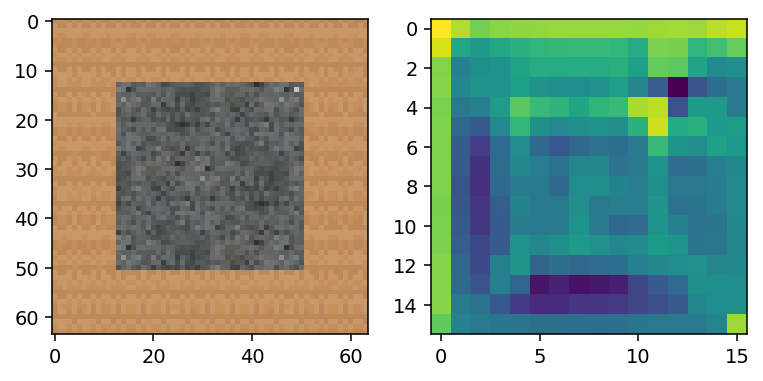

In [26]:
def plot_obs_activation(data, obs_idx, layer, channel):
    obs = np.expand_dims(data[obs_idx]['obs'].to_numpy(), axis=0)
    activations = visualization.get_activations(obs, hook, layer)
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(np.transpose(obs[0], (1, 2, 0)))
    axarr[1].imshow(activations[0, channel])
    plt.show()


plot_obs_activation(data_all, 0, 'embedder.block2.res1.resadd_out', 55)

Even in the extreme scenario, which visually seemed to make it hard to determine the presence of cheese by looking at the influence on the rats local behavior, in terms of activations it's pretty clear that the cheese has some influence on the agent at all times, and that this influence is noticeable and detectable.

This graph also shows some interesting behavior in the intermediate layers, showing that early layers require more neurons to detect the presence of cheese, and this reliance on number of activations decreases steadily the deeper you go. This could be further evidence of the fact that deeper layers codigy more sophisticated features.

So the hypothesis about the cheese having some localized influence is discarded, meaning that if there's a "cheese shard", it doesn't lie dormant until the mouse is sufficiently close. Instead, the cheese shard is always active, always applying some influence on the agents actions.

Yet, this is not a sufficient answer to explain the behavior seen in the above experiments. The cheese shard might always be active, but it is clearly not always the dominant influence in the agent's actions. We can redefine the cheese area of influence as that one where the agent's actions are sufficiently influenced by the cheese.

How can we specify this more technically?

Instead of trying to predict the presence of cheese by looking at the activations (which we already know is feasible at any stage with sufficient activations) we could instead look at the magnitude of the difference of the activations between the agent that sees cheese far away, and the agent that doesn't see any cheese at all. My hypothesis is that the magnitude will be small near the policy layer, but will be significant in the intermediate layers, which are responsible for detecting valuable features in the environment.

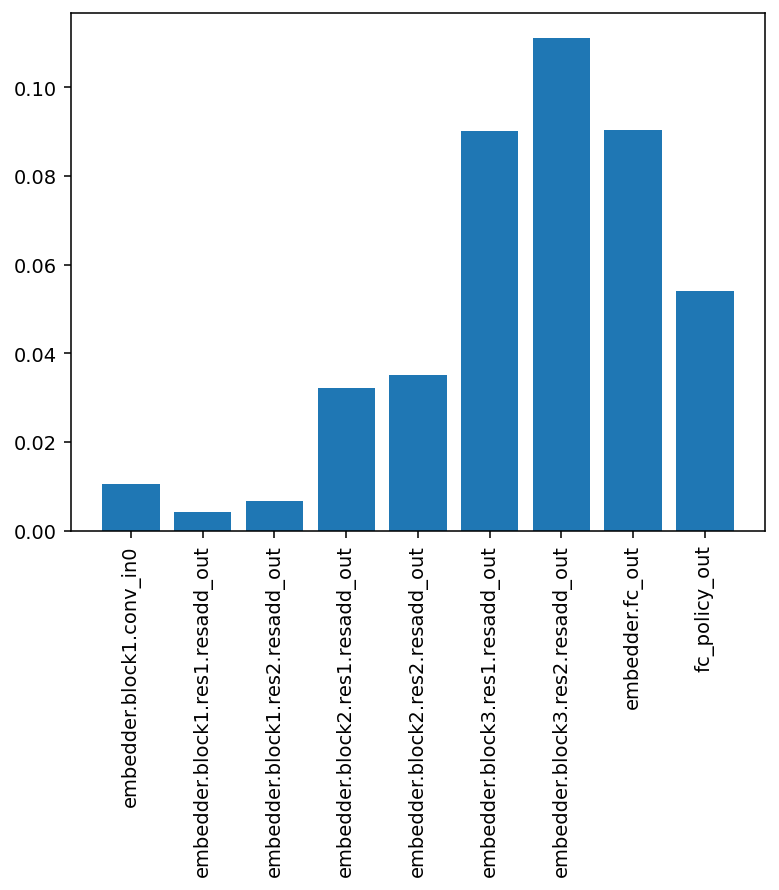

In [27]:
# Retrieve differing environments from previously collected data
no_cheese_idx = 0
cheese_idx = 4

# Collect activations from layers of interest in both environments
def get_activations(obs, layers):
    obs = np.expand_dims(obs, axis=0)
    activations = []
    for layer in layers:
        activation = visualization.get_activations(obs, hook, layer)
        activations.append(activation)


    return activations

def normalized_frobenius_norm(tensor):
    """
    To make magnitude comparison across layers, we need to normalize
    by the number of dimensions each layer has. This function computes
    the average magnitude per 
    """
    norm = np.linalg.norm(tensor)
    n_elements = np.prod(tensor.shape)
    return norm / np.sqrt(n_elements)

def get_activations_diff(obs1, obs2, layers):
    obs1_activations = get_activations(obs1, layers)
    obs2_activations = get_activations(obs2, layers)

    magnitudes = {}
    for i, (l1, l2) in enumerate(zip(obs1_activations, obs2_activations)):
        layer_name = layers[i]
        diff = l1 - l2
        mag = normalized_frobenius_norm(diff)
        magnitudes[layer_name] = (mag, diff)

    return magnitudes

def plot_activations_diff(diffs: dict):
    mags = list([vals[0] for vals in diffs.values()])
    plt.bar(diffs.keys(), mags)
    plt.xticks(rotation=90)
    plt.show()

nc_obs = data_all[no_cheese_idx]['obs'].to_numpy()
c_obs = data_all[cheese_idx]['obs'].to_numpy()

far_away_diffs = get_activations_diff(nc_obs, c_obs, value_labels_to_plot)

plot_activations_diff(far_away_diffs)

Success! This shows a clear drop on activation difference between `embedder.block3.res2.resadd_out` and `embedder.fc_out`. How does this look compared to when the agent is close to the cheese?

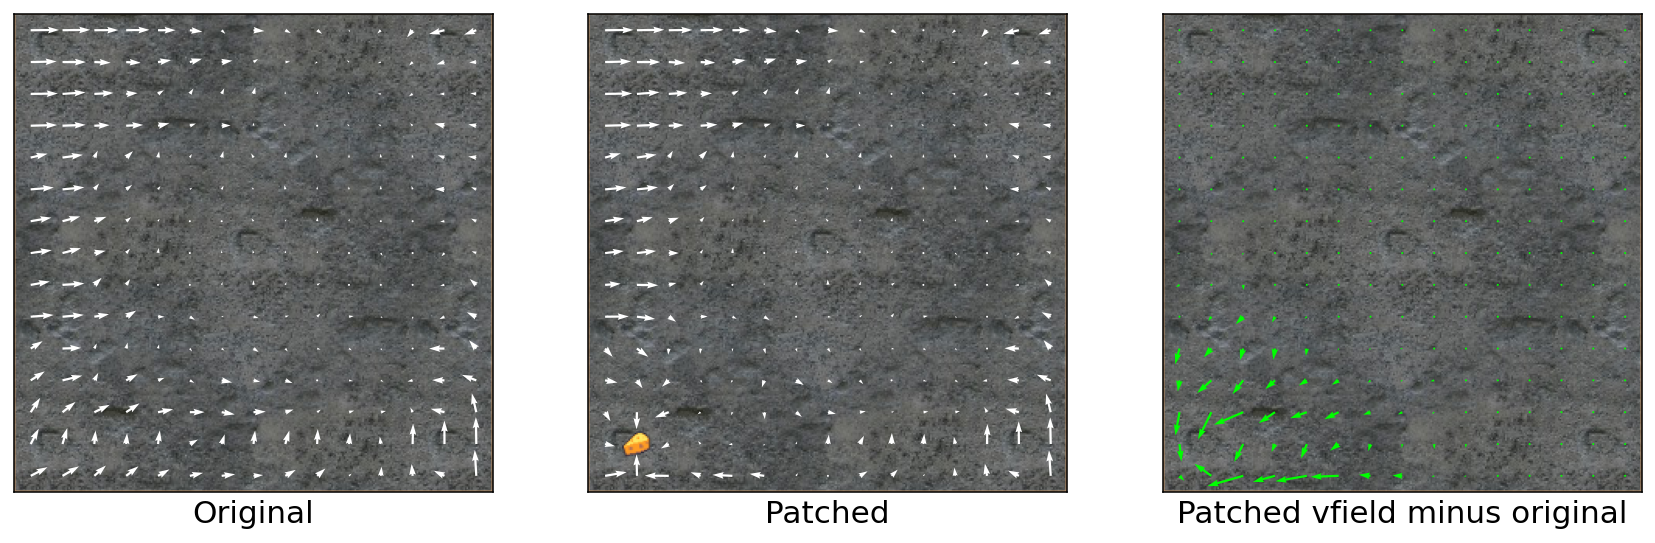

In [28]:
empty_maze_cheese_vfields((1, 1), policy, size=15, mouse_loc=(1, 1))

I will use the case above to investigate this activations. This is because while the agent is pretty much in the visual area of influence of the cheese, its behavior in the block (0, 0) doesn't change that much. If the `embedder.fc_out` layer is in charge of determining which shard is active, we should see a big activation difference even if the final behavior is the same

In [29]:
size = 15
cheese_loc = (1, 1)

venv = create_venv(num=1, start_level=0, num_levels=1)
set_empty_maze(venv, size=size)
cheese_env = maze.copy_venv(venv, 0)
set_empty_maze(cheese_env, size=size, cheese_loc=cheese_loc)

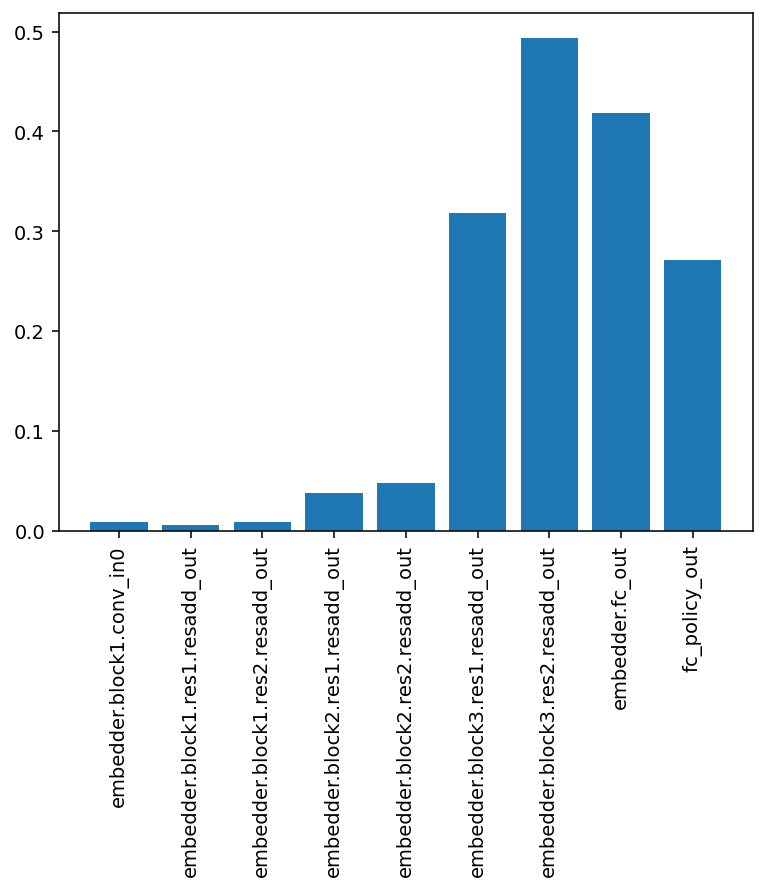

In [30]:
c_obs = cheese_env.reset()[0].astype(np.float32)
nc_obs = venv.reset()[0].astype(np.float32)

close_diffs = get_activations_diff(nc_obs, c_obs, value_labels_to_plot)
plot_activations_diff(close_diffs)

It might be worth to plot the difference between the two, to see where the magnitude has changed

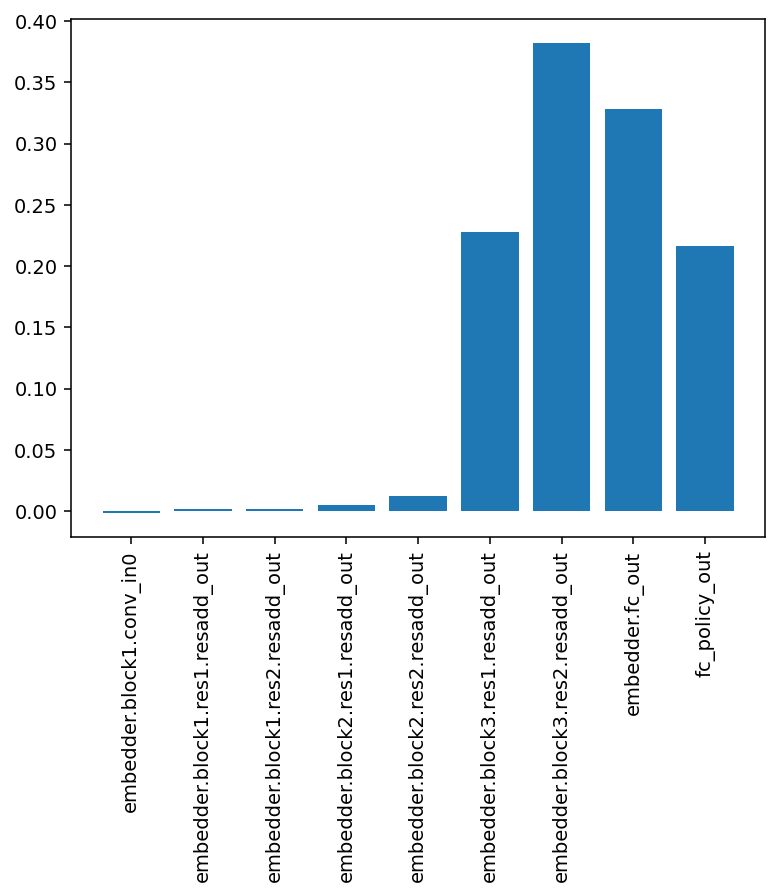

In [31]:
situation_diffs = {k: (close_diffs[k][0] - far_away_diffs[k][0], close_diffs[k][1] - far_away_diffs[k][1]) for k in value_labels_to_plot}
plot_activations_diff(situation_diffs)

The most affected layers by this change in situation are `embedder.block3.res2.resadd_out`, `embedder.block3.res1.resadd_out` and `embedder.fc_out`. Going by activations alone, it would appear that the most influential layer is `embedder.block3.res2.resadd_out`, but we might want to explore the activation difference as the mouse gets closer and closer to the cheese.

Going back to the extreme scenario where the mouse is at the top-right corner, and the cheese at the bottom-left corner, the relationship between influence strength and distance doesn't seem to be linear.

In [32]:
# I'm aware this is extremely wasteful. I haven't had the time to get
# familiar with all the tools to create different environments
# Might improve this later on
orig_venv = create_venv(num=1, start_level=SEED, num_levels=1)
no_cheese_venv = set_empty_maze(orig_venv, size)
no_cheese_venvs = maze.venv_with_all_mouse_positions(no_cheese_venv)[0]
cheese_venv = set_empty_maze(orig_venv, size, cheese_loc=(0, 0))
cheese_venvs = maze.venv_with_all_mouse_positions(cheese_venv)[0]

In [33]:
distance_mags = {}
distance_diffs = {}
for offset in range(15, cheese_venvs.num_envs, 16):
    c_venv = copy_venv(cheese_venvs, offset)
    nc_venv = copy_venv(no_cheese_venvs, offset + 1) # Account for the additional valid position

    c_obs = c_venv.reset()[0].astype(np.float32)
    nc_obs = nc_venv.reset()[0].astype(np.float32)
    diff = get_activations_diff(nc_obs, c_obs, value_labels_to_plot)
    distance_mags[offset] = {k: v[0] for k, v in diff.items()}
    distance_diffs[offset] = {k: v[1] for k, v in diff.items()}

In [34]:
dist_mags_df = pd.DataFrame(distance_mags)

In [35]:
dist_mags_df

15        31        47        63   \
embedder.block1.conv_in0         0.010511  0.010511  0.010511  0.010511   
embedder.block1.res1.resadd_out  0.003975  0.004139  0.004073  0.004082   
embedder.block1.res2.resadd_out  0.006009  0.006716  0.006592  0.006614   
embedder.block2.res1.resadd_out  0.031100  0.028995  0.031433  0.032945   
embedder.block2.res2.resadd_out  0.043231  0.035840  0.036628  0.037678   
embedder.block3.res1.resadd_out  0.458097  0.264930  0.198595  0.106044   
embedder.block3.res2.resadd_out  0.953875  0.496727  0.268175  0.130388   
embedder.fc_out                  1.429472  0.667301  0.289422  0.114177   
fc_policy_out                    1.208694  0.824187  0.258866  0.058711   

                                      79        95        111       127  \
embedder.block1.conv_in0         0.010511  0.010511  0.010511  0.010511   
embedder.block1.res1.resadd_out  0.004082  0.004082  0.004082  0.004082   
embedder.block1.res2.resadd_out  0.006616  0.006616  0.006616  0.006616   
embedder.block2.res1.resadd_out  0.032521  0.032357  0.032269  0.032267   
embedder.block2.res2.resadd_out  0.035541  0.035100  0.034992  0.035038   
embedder.block3.res1.resadd_out  0.079559  0.084395  0.085492  0.087175   
embedder.block3.res2.resadd_out  0.103113  0.106166  0.106007  0.105678   
embedder.fc_out                  0.099487  0.102648  0.095163  0.097346   
fc_policy_out                    0.070878  0.048833  0.053048  0.056772   

                                      143       159       175       191  \
embedder.block1.conv_in0         0.010511  0.010511  0.010511  0.010511   
embedder.block1.res1.resadd_out  0.004082  0.004082  0.004082  0.004082   
embedder.block1.res2.resadd_out  0.006616  0.006616  0.006616  0.006616   
embedder.block2.res1.resadd_out  0.032267  0.032267  0.032267  0.032267   
embedder.block2.res2.resadd_out  0.035032  0.035028  0.035026  0.035026   
embedder.block3.res1.resadd_out  0.087353  0.087984  0.088896  0.089611   
embedder.block3.res2.resadd_out  0.104870  0.106860  0.108809  0.110821   
embedder.fc_out                  0.092387  0.090986  0.088090  0.089282   
fc_policy_out                    0.049898  0.045617  0.044562  0.049661   

                                      207       223  
embedder.block1.conv_in0         0.010511  0.010511  
embedder.block1.res1.resadd_out  0.004082  0.004082  
embedder.block1.res2.resadd_out  0.006616  0.006616  
embedder.block2.res1.resadd_out  0.032267  0.032267  
embedder.block2.res2.resadd_out  0.035026  0.035026  
embedder.block3.res1.resadd_out  0.090003  0.090069  
embedder.block3.res2.resadd_out  0.111256  0.111209  
embedder.fc_out                  0.090643  0.090332  
fc_policy_out                    0.050373  0.054139

<Axes: >

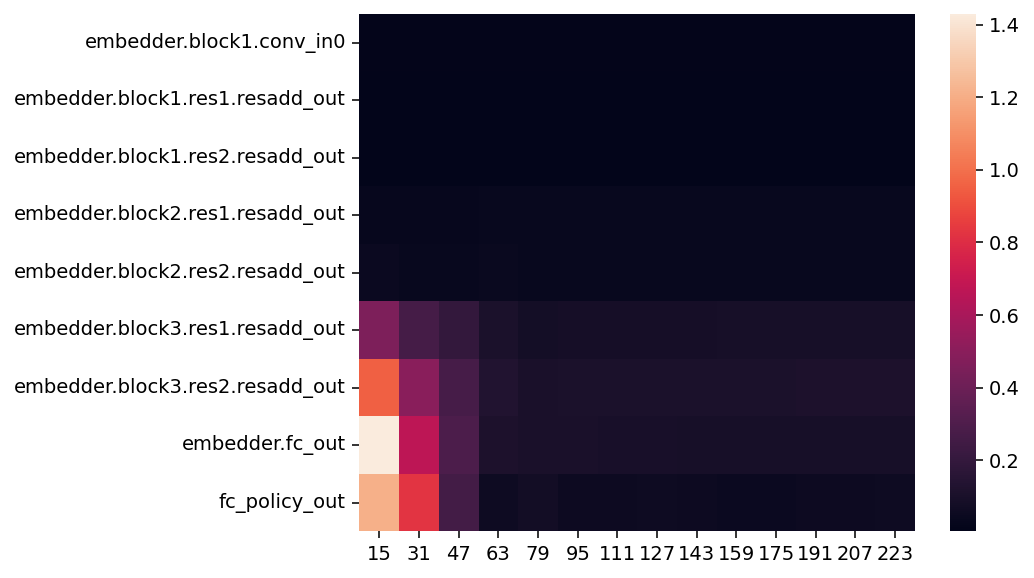

In [36]:
import seaborn as sns

# normalized_diffs = dist_diffs_df.T.divide(dist_diffs_df.T.max(axis=0)).T

sns.heatmap(dist_mags_df)

In [37]:
fc_out_diffs = [distance_diffs[k]['embedder.fc_out'] for k in distance_diffs.keys()]

In [38]:
avg_fc_out_diffs = sum(fc_out_diffs)/len(fc_out_diffs)

In [39]:
avg_fc_out_diffs[:, 163]

array([0.54310447], dtype=float32)

In [40]:
fc_out_diffs[0].argmax()

163

In [41]:
fc_out_diffs[1].argmax()

163

In [42]:
[fc_out_diffs[i].argmax() for i in range(len(fc_out_diffs))]

[163, 163, 163, 72, 82, 72, 72, 81, 81, 113, 62, 106, 62, 81]

In [43]:
from procgen_tools import patch_utils

def deactivate_neuron(idx):
    def deact(outp):
        mask = np.ones_like(outp)
        mask[idx] = 0
        return outp * mask
    
patch_fn = deactivate_neuron(163)

channel_patch = patch_utils.channel_patch_or_broadcast('embedder.fc_out', patch_fn=patch_fn)

In [44]:
fig, axs, info = patch_utils.compare_patched_vfields(cheese_venvs[0], [channel_patch], hook, render_padding=False, show_components=True)

TypeError: 'ScaledFloatFrame' object is not subscriptable